# 2023-01-23

In [9]:
from __future__ import annotations
import math
from typing import Callable, Union, Optional, Tuple, List, Set

import graphviz
import matplotlib.pyplot as plt
import numpy as np
import random

from graphviz import Digraph

import torch

import matplotlib.pyplot as plt

In [10]:
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [11]:
class Value:
    def __init__(
        self,
        data: float,
        _childern: Optional[tuple] = None,
        _op: str = None,
        label: Optional[str] = None,
    ) -> None:
        self._data = data
        self._grad: float = 0.0
        self._backward = lambda: None
        self._prev = set(()) if not _childern else set(_childern)
        self._op = _op
        self._label = "" if not label else label

    def _parse_to_value(func: Callable):
        def wrapper(self, value):
            parsed_val = value if isinstance(value, Value) else Value(value)
            return func(self, parsed_val)

        return wrapper

    @property
    def label(self) -> str:
        return self._label

    @label.setter
    def label(self, val: str) -> None:
        self._label = val

    @property
    def grad(self) -> float:
        return self._grad

    @grad.setter
    def grad(self, val: float) -> None:
        self._grad = val

    @property
    def data(self) -> float:
        return self._data

    @data.setter
    def data(self, val: float) -> None:
        self._data = val

    def __repr__(self) -> str:
        return f"Value(data={self._data},label='{self._label}')"

    @_parse_to_value
    def __add__(self, other) -> float:
        out = Value(self._data + other._data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __radd__(self, other) -> float:
        return self + other

    def __sub__(self, other):  # self - other
        return self + (-other)

    @_parse_to_value
    def __mul__(self, other) -> float:
        out = Value(self._data * other._data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward

        return out

    def __neg__(self):
        return self * -1

    def __rmul__(self, other):
        return self * other

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self._grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [12]:
a = Value(10, label="a")
b = a + a

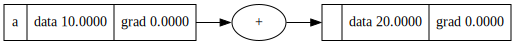

In [13]:
draw_dot(b)

In [14]:
b.backward()

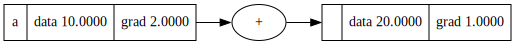

In [15]:
draw_dot(b)

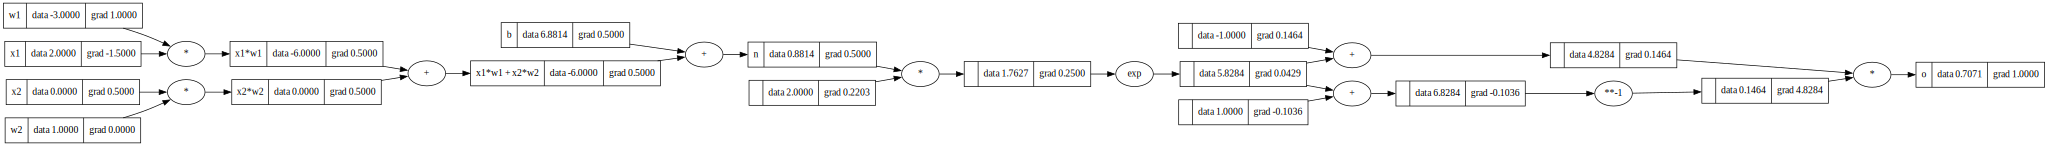

In [17]:
# inputs x1,x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1,w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of the neuron
b = Value(6.8813735870195432, label="b")
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1
x1w1.label = "x1*w1"
x2w2 = x2 * w2
x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b
n.label = "n"
# (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
# -----
e = (2 * n).exp()
o = (e - 1) / (e + 1)
# -----
o.label = "o"
o.backward()
draw_dot(o)

### PyTorch API

In [18]:
x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()
b.requires_grad = True
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("---")
print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


### Neural Net

In [19]:
import random


class Neuron:
    def __init__(self, nin):
        self.w: List[Value] = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b: Value = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    def __init__(self, nin: int, nouts: List[int]):
        sz = [nin] + nouts
        self.layers: List[Layer] = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

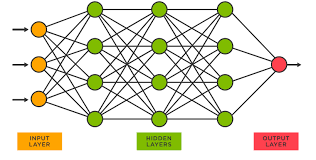

```python
INPUT_LAYER = 3 # three features (age, height, weight)
HIDDEN_LAYERS: List[int] = [4, 4, 4]
OUTPUT_LAYER: List[int] = [1]
MLP(INPUT_LAYER, HIDDEN_LAYERS + OUTPUT_LAYER)
MLP(3, [4, 4, 4, 1])
```

In [47]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.4832577891850247,label='')

In [48]:
len(n.parameters())

41

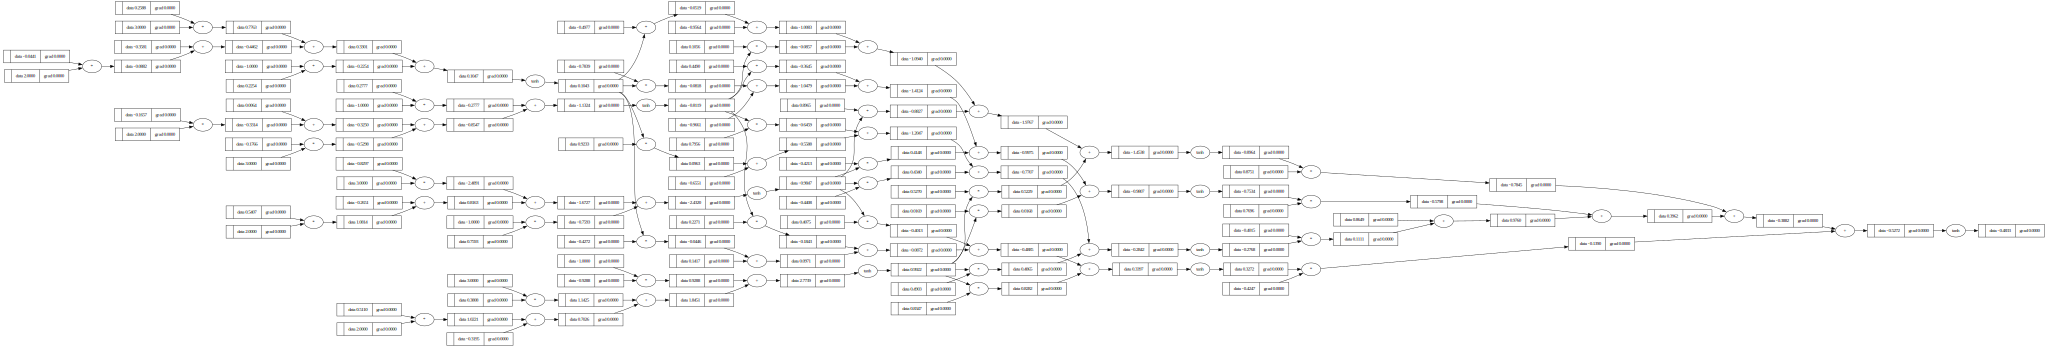

In [49]:
draw_dot(n(x))

In [50]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]  # desired targets

In [51]:
ypred = [n(x) for x in xs]

In [52]:
loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))

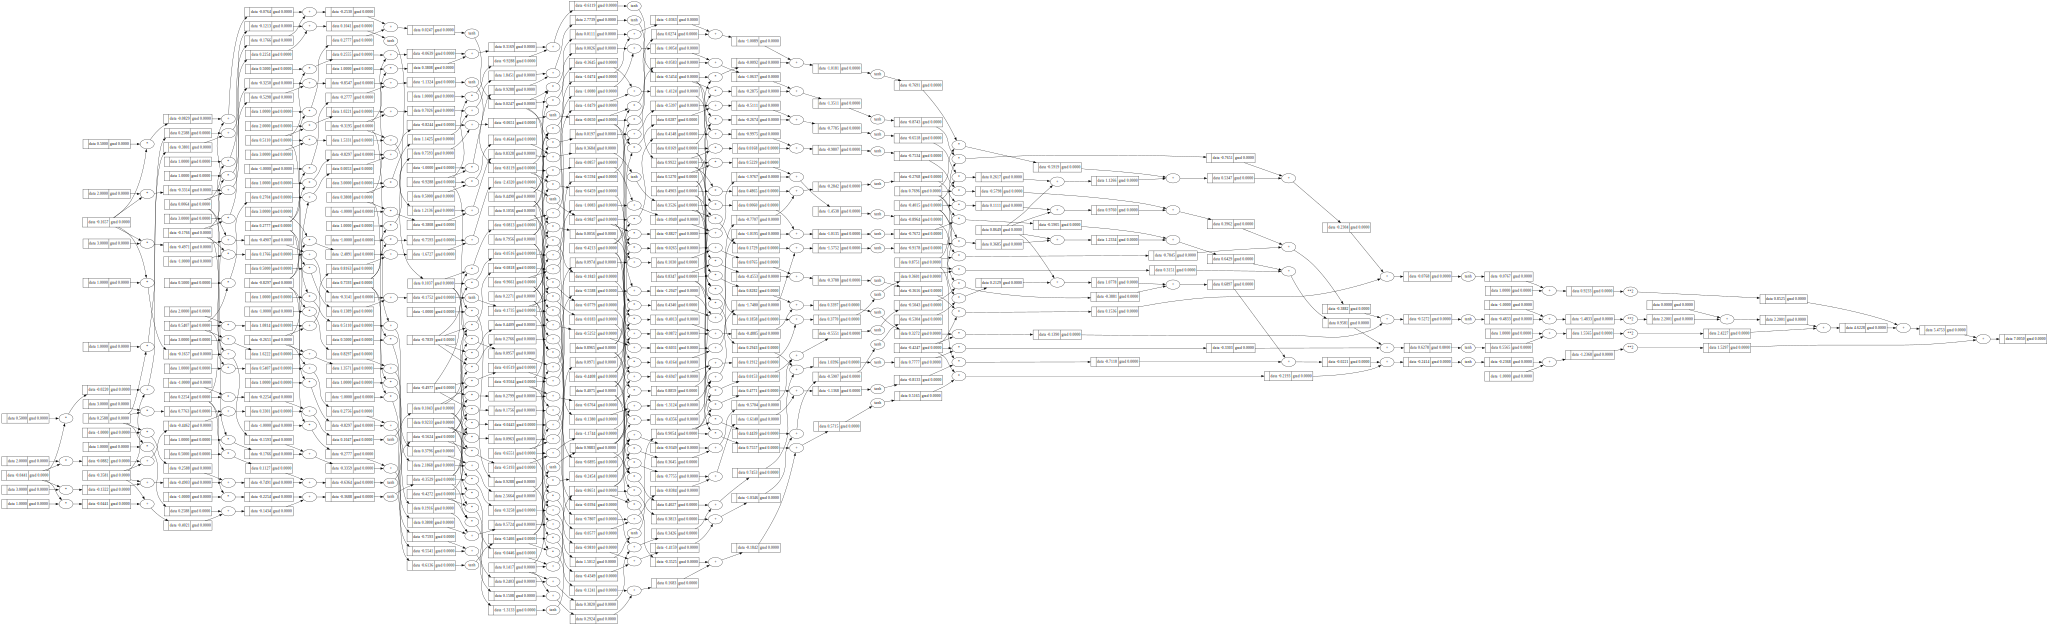

In [53]:
draw_dot(loss)

0 Value(data=7.004965348212793,label='')
1 Value(data=2.711579565034107,label='')
2 Value(data=1.3412955756696978,label='')
3 Value(data=0.27192424010984456,label='')
4 Value(data=0.08154368559013629,label='')
5 Value(data=0.0565545813951272,label='')
6 Value(data=0.044164399436847294,label='')
7 Value(data=0.036620304828045014,label='')
8 Value(data=0.03149987939156297,label='')
9 Value(data=0.02777616871847608,label='')
10 Value(data=0.024934247417570388,label='')
11 Value(data=0.02268609391275634,label='')
12 Value(data=0.02085756188923908,label='')
13 Value(data=0.019336997441950707,label='')
14 Value(data=0.01804944514930479,label='')
15 Value(data=0.016942681638502294,label='')
16 Value(data=0.015979186361314218,label='')
17 Value(data=0.01513129508215941,label='')
18 Value(data=0.014378153558456076,label='')
19 Value(data=0.013703736047279553,label='')


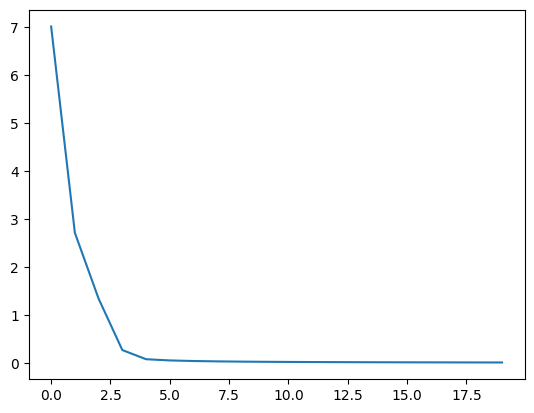

In [54]:
epochs = 20
lr = 1e-1

loss_vals: List[float] = []

for k in range(epochs):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))

    loss_vals.append(loss.data)

    # clearning gradients
    for p in n.parameters():
        p.grad = 0.0

    # backward pass
    loss.backward()

    for p in n.parameters():
        p.data -= lr * p.grad

    print(k, loss)

plt.plot(loss_vals)

In [55]:
[n(x) for x in xs]

[Value(data=0.9674897146335149,label=''),
 Value(data=-0.9392695392610518,label=''),
 Value(data=-0.9198755075852596,label=''),
 Value(data=0.9560628149895878,label='')]